In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import warnings
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from itertools import repeat
from time import perf_counter
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from matplotlib import pyplot as plt
from lightgbm import plot_importance
from lightgbm import plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
pd.set_option('display.max_columns', None)

In [3]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)
df.head(3)

,imp_id,content_id,server_time_kst_x,imp_hour,bid_price_x,click_label,user_gender,user_age_group,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,name,keyword,price,flag_used,category1,emergency_cnt,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count,m_time,content_img_url
0,9919612e44382421285c,162261579,2021-09-01 00:01:42.466000+09:00,0,55,0,F,1,16,3,0,0,0,2,Z플립 5G 256GB [그레이] 48082 (S급),"Z플립5G,제트플립,제트플립5G,갤럭시Z플립5G,Z플립5G그레이",580000.0,1.0,600,0.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0,1629443915,https://media.bunjang.co.kr/product/162261579_...
1,9919612e444924217d59,145430389,2021-09-01 00:01:42.466000+09:00,0,70,0,F,2,26,0,0,0,0,0,최저가60 무선청소기 기펠상위모델 국내브랜드 셀프스텐드 정품무배,"기펠청소기,무선청소기,코드제로,에어슬림",135000.0,2.0,600,0.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0,1629943339,https://media.bunjang.co.kr/product/145430389_...
2,97f9612e444d18489e0e,98827336,2021-09-01 00:01:40.339000+09:00,0,50,0,F,5,53,0,0,0,0,0,정품 원터치텐트 낚시텐트 자외선차단텐트 방수텐트 캠핑텐트 간편 자동텐트,"원터치텐트간편텐트,낚시텐트등산텐트,자외선차단방수텐트,자동텐트감성캠핑,캠핑용품그늘막",26000.0,2.0,700,0.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0,1627289231,https://media.bunjang.co.kr/product/98827336_1...


In [4]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [5]:
data = reorganization(df)
data.columns

Index(['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used',
       'category1', 'emergency_cnt', 'user_age', 'user_following_cnt',
       'user_pay_count', 'user_parcel_post_count', 'user_transfer_count',
       'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt',
       'adver_favorite_count', 'adver_grade', 'adver_item_count',
       'adver_interest', 'adver_review_count', 'adver_comment_count',
       'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count',
       'adver_chat_count'],
      dtype='object')

In [6]:
data.head(3)

,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,F,0,0,1,1.0,600,0.0,16,3,0,0,0,2,580000.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0
1,F,0,0,2,2.0,600,0.0,26,0,0,0,0,0,135000.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0
2,F,0,0,5,2.0,700,0.0,53,0,0,0,0,0,26000.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0


In [7]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [8]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [9]:
X = df
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

# ## create train and validation datasets (8:2 ratio)
# x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)

# print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
# print()
# print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
# print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_train.shape))
# print()

X features' name (10): ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 27), (1144850,), (252739, 27), (1144850,))



In [10]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200)
lgb_model = lgb_model.fit(X_train, y_train, early_stopping_rounds=10) #eval_metric="logloss", eval_set = [(X_test, y_test)])
lgb_model

[1]	valid_0's binary_logloss: 0.598139	valid_0's binary_logloss: 0.598139
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.520329	valid_0's binary_logloss: 0.520329
[3]	valid_0's binary_logloss: 0.455444	valid_0's binary_logloss: 0.455444
[4]	valid_0's binary_logloss: 0.400598	valid_0's binary_logloss: 0.400598
[5]	valid_0's binary_logloss: 0.353747	valid_0's binary_logloss: 0.353747
[6]	valid_0's binary_logloss: 0.313388	valid_0's binary_logloss: 0.313388
[7]	valid_0's binary_logloss: 0.278384	valid_0's binary_logloss: 0.278384
[8]	valid_0's binary_logloss: 0.247853	valid_0's binary_logloss: 0.247853
[9]	valid_0's binary_logloss: 0.221099	valid_0's binary_logloss: 0.221099
[10]	valid_0's binary_logloss: 0.19756	valid_0's binary_logloss: 0.19756
[11]	valid_0's binary_logloss: 0.176781	valid_0's binary_logloss: 0.176781
[12]	valid_0's binary_logloss: 0.158385	valid_0's binary_logloss: 0.158385
[13]	valid_0's binary_logloss: 0.142058	valid_0's

LGBMClassifier(n_estimators=200, random_state=2022)

In [11]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(X_train, y_train)))
print('test score : {:.3f}'.format(lgb_model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, lgb_model.predict(X_test)))
print(confusion_matrix(y_test, lgb_model.predict(X_test)))

train score : 1.000
test score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    245325
           1       1.00      1.00      1.00      7414

    accuracy                           1.00    252739
   macro avg       1.00      1.00      1.00    252739
weighted avg       1.00      1.00      1.00    252739

[[245325      0]
 [     0   7414]]


In [12]:
lgb_model.predict_proba(X_test)

array([[9.99999998e-01, 1.63938288e-09],
       [1.63938285e-09, 9.99999998e-01],
       [9.99999998e-01, 1.63938288e-09],
       ...,
       [9.99999998e-01, 1.63938288e-09],
       [9.99999998e-01, 1.63938288e-09],
       [9.99999998e-01, 1.63938288e-09]])

In [13]:
# GridSearchCV(모델, param_grid, cv, scoring, n_jobs, verbose)
param_grid = {
    'max_depth' :[50, 100, 150], 
    'learning_rate' :[0.001, 0.01, 0.1],
}

# 전처리를 거친 x_train으로 grid search cross validation 수행
gs = GridSearchCV(lgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring = 'f1')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_estimators=200, random_state=2022),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [50, 100, 150]},
             scoring='f1', verbose=1)

In [16]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(X_test)

In [17]:
print(f'optimized parameters: {model}')

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)


In [18]:
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

test score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    245325
           1       1.00      1.00      1.00      7414

    accuracy                           1.00    252739
   macro avg       1.00      1.00      1.00    252739
weighted avg       1.00      1.00      1.00    252739

[[245325      0]
 [     0   7414]]


In [19]:
model.predict_proba(X_test)

array([[0.59066875, 0.40933125],
       [0.40933125, 0.59066875],
       [0.59066875, 0.40933125],
       ...,
       [0.59066875, 0.40933125],
       [0.59066875, 0.40933125],
       [0.59066875, 0.40933125]])

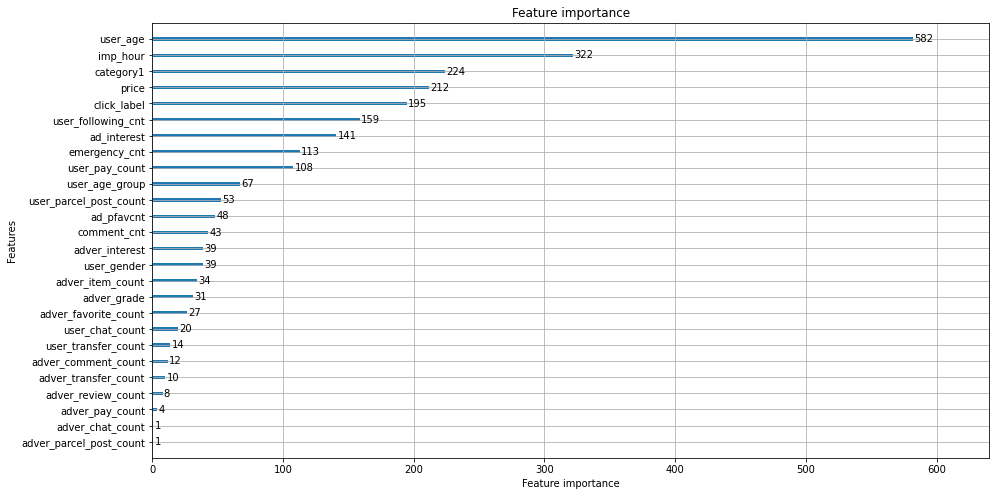

In [21]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(lgb_model, ax=ax)
plt.show()

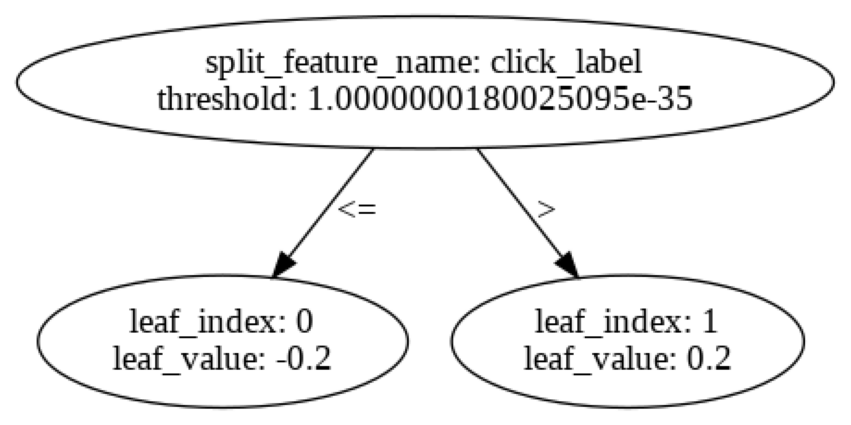

In [22]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(lgb_model, ax=ax)

# 훈련/검증데이터 분리

In [23]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)
df.head(3)

,imp_id,content_id,server_time_kst_x,imp_hour,bid_price_x,click_label,user_gender,user_age_group,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,name,keyword,price,flag_used,category1,emergency_cnt,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count,m_time,content_img_url
0,9919612e44382421285c,162261579,2021-09-01 00:01:42.466000+09:00,0,55,0,F,1,16,3,0,0,0,2,Z플립 5G 256GB [그레이] 48082 (S급),"Z플립5G,제트플립,제트플립5G,갤럭시Z플립5G,Z플립5G그레이",580000.0,1.0,600,0.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0,1629443915,https://media.bunjang.co.kr/product/162261579_...
1,9919612e444924217d59,145430389,2021-09-01 00:01:42.466000+09:00,0,70,0,F,2,26,0,0,0,0,0,최저가60 무선청소기 기펠상위모델 국내브랜드 셀프스텐드 정품무배,"기펠청소기,무선청소기,코드제로,에어슬림",135000.0,2.0,600,0.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0,1629943339,https://media.bunjang.co.kr/product/145430389_...
2,97f9612e444d18489e0e,98827336,2021-09-01 00:01:40.339000+09:00,0,50,0,F,5,53,0,0,0,0,0,정품 원터치텐트 낚시텐트 자외선차단텐트 방수텐트 캠핑텐트 간편 자동텐트,"원터치텐트간편텐트,낚시텐트등산텐트,자외선차단방수텐트,자동텐트감성캠핑,캠핑용품그늘막",26000.0,2.0,700,0.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0,1627289231,https://media.bunjang.co.kr/product/98827336_1...


In [24]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [25]:
data = reorganization(df)
data.columns

Index(['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used',
       'category1', 'emergency_cnt', 'user_age', 'user_following_cnt',
       'user_pay_count', 'user_parcel_post_count', 'user_transfer_count',
       'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt',
       'adver_favorite_count', 'adver_grade', 'adver_item_count',
       'adver_interest', 'adver_review_count', 'adver_comment_count',
       'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count',
       'adver_chat_count'],
      dtype='object')

In [26]:
data.head(3)

,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,F,0,0,1,1.0,600,0.0,16,3,0,0,0,2,580000.0,0.0,120.0,4.0,2063.0,7539.0,784.0,3424.0,755.0,392.0,677.0,0.0,5.0,236.0
1,F,0,0,2,2.0,600,0.0,26,0,0,0,0,0,135000.0,3.0,5385.0,153.0,799.0,5520.0,433.0,16794.0,570.0,250.0,942.0,0.0,57.0,11.0
2,F,0,0,5,2.0,700,0.0,53,0,0,0,0,0,26000.0,12.0,29950.0,759.0,2120.0,3252.0,2053.0,32794.0,351.0,441.0,166.0,0.0,16.0,3.0


In [27]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [28]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [29]:
X = df
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_val.shape))
print()

X features' name (10): ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 27), (1144850,), (252739, 27), (1144850,))

# of train_data's rows: 915880 
# of validation_data's rows: 228970

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((915880, 27), (915880,), (228970, 27), (228970,))



In [33]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200)
lgb_model = lgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set = [(x_val, y_val)])
lgb_model

[1]	valid_0's binary_logloss: 0.598139	valid_0's binary_logloss: 0.598139
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.520329	valid_0's binary_logloss: 0.520329
[3]	valid_0's binary_logloss: 0.455444	valid_0's binary_logloss: 0.455444
[4]	valid_0's binary_logloss: 0.400598	valid_0's binary_logloss: 0.400598
[5]	valid_0's binary_logloss: 0.353747	valid_0's binary_logloss: 0.353747
[6]	valid_0's binary_logloss: 0.313388	valid_0's binary_logloss: 0.313388
[7]	valid_0's binary_logloss: 0.278384	valid_0's binary_logloss: 0.278384
[8]	valid_0's binary_logloss: 0.247853	valid_0's binary_logloss: 0.247853
[9]	valid_0's binary_logloss: 0.221099	valid_0's binary_logloss: 0.221099
[10]	valid_0's binary_logloss: 0.19756	valid_0's binary_logloss: 0.19756
[11]	valid_0's binary_logloss: 0.176781	valid_0's binary_logloss: 0.176781
[12]	valid_0's binary_logloss: 0.158385	valid_0's binary_logloss: 0.158385
[13]	valid_0's binary_logloss: 0.142058	valid_0's

LGBMClassifier(n_estimators=200, random_state=2022)

In [34]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(x_train, y_train)))
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, lgb_model.predict(x_val)))
print(confusion_matrix(y_val, lgb_model.predict(x_val)))

train score : 1.000
validation score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114485
           1       1.00      1.00      1.00    114485

    accuracy                           1.00    228970
   macro avg       1.00      1.00      1.00    228970
weighted avg       1.00      1.00      1.00    228970

[[114485      0]
 [     0 114485]]


In [35]:
lgb_model.predict_proba(x_val)

array([[2.00234673e-09, 9.99999998e-01],
       [2.00234673e-09, 9.99999998e-01],
       [2.00234673e-09, 9.99999998e-01],
       ...,
       [2.00234673e-09, 9.99999998e-01],
       [9.99999998e-01, 2.00234677e-09],
       [9.99999998e-01, 2.00234677e-09]])

In [36]:
# GridSearchCV(모델, param_grid, cv, scoring, n_jobs, verbose)
param_grid = {
    'max_depth' :[50, 100, 150], 
    'learning_rate' :[0.001, 0.01, 0.1],
}

# 전처리를 거친 x_train으로 grid search cross validation 수행
gs = GridSearchCV(lgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring = 'f1')
gs.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_estimators=200, random_state=2022),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [50, 100, 150]},
             scoring='f1', verbose=1)

In [42]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(x_val)

In [43]:
print(f'optimized parameters: {model}')

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)


In [45]:
print('validation score : {:.3f}'.format(model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, data_pred))
print(confusion_matrix(y_val, data_pred))

validation score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114485
           1       1.00      1.00      1.00    114485

    accuracy                           1.00    228970
   macro avg       1.00      1.00      1.00    228970
weighted avg       1.00      1.00      1.00    228970

[[114485      0]
 [     0 114485]]


In [46]:
model.predict_proba(x_val)

array([[0.40933125, 0.59066875],
       [0.40933125, 0.59066875],
       [0.40933125, 0.59066875],
       ...,
       [0.40933125, 0.59066875],
       [0.59066875, 0.40933125],
       [0.59066875, 0.40933125]])

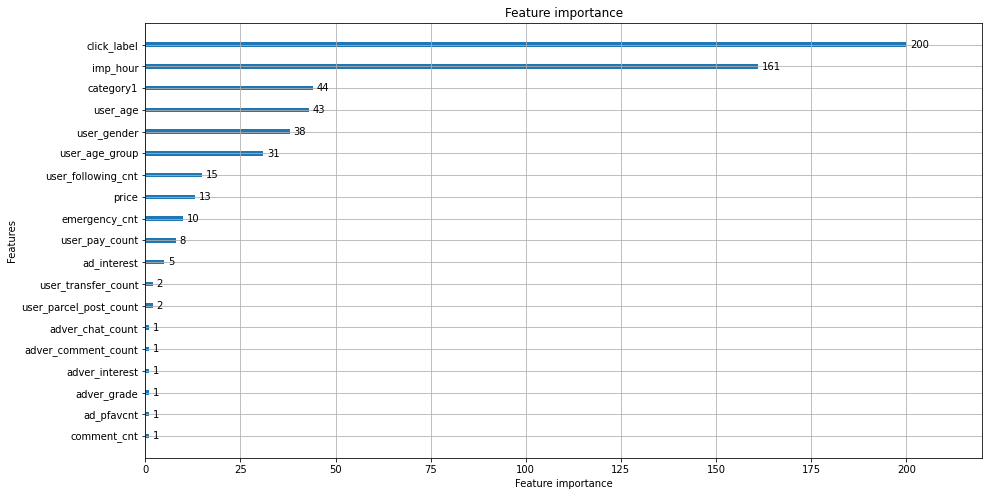

In [49]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(model, ax=ax)
plt.show()

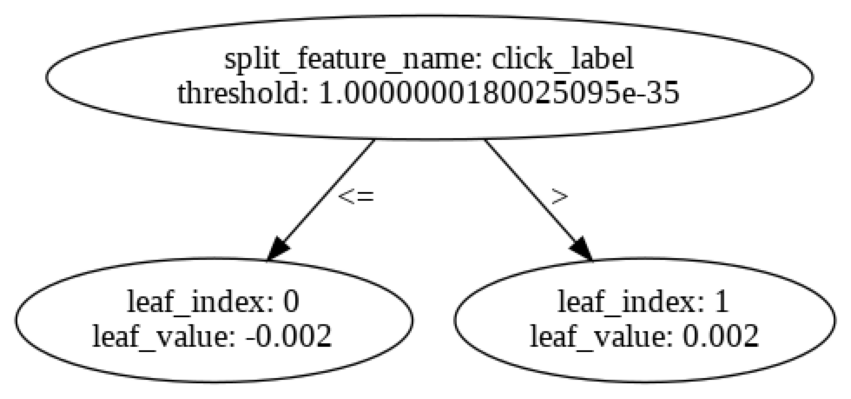

In [50]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(model, ax=ax)

In [51]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(X_test)

print(f'optimized parameters: {model}')
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)
test score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    245325
           1       1.00      1.00      1.00      7414

    accuracy                           1.00    252739
   macro avg       1.00      1.00      1.00    252739
weighted avg       1.00      1.00      1.00    252739

[[245325      0]
 [     0   7414]]


# 최적의 하이퍼파라미터로 재 모델링

In [53]:
file_name = 'final_data_v2.csv'
file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
df = pd.read_csv(file_path+file_name, encoding='utf-8')
df.rename(columns={'category_id_1':'category1'}, inplace=True)

In [54]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }

def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' #[:-16]는 본인 경로에 맞게 있어도 되고 없어도 됨.
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [55]:
data = reorganization(df)

In [56]:
def preprocessing(df):
    # 데이터 유형별 분류하기
    modified_df = pd.DataFrame()

    for i, c in enumerate(df.columns): 
        if (c in cols['obj']) | (c in cols['cat']): 
          if 'click' in c:    # click_label 컬럼 = y 변수로 사용 (그대로 두기)
                modified_df = pd.concat([modified_df, df[c]], axis=1)
          else:
            dummied_data = LabelEncoder().fit_transform(df[[c]])
            dummied_data = pd.DataFrame(dummied_data, columns = [c])
            modified_df = pd.concat([modified_df, dummied_data], axis=1)

        else:
            scaled_num_data = RobustScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)

    print('---- Data info ----')
    print(f'Modified DF columns: {modified_df.columns.to_list()}')
    print(f'# of Modified DF columns: {modified_df.shape[1]}')
    print(f'DataFrame has no null?', end = ' ')
    if df.isnull().sum().count() == df.shape[1]:
      print('Yes')
    else:
      print('No')
    return modified_df

In [57]:
df = preprocessing(data)
df.head(3)

---- Data info ----
Modified DF columns: ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']
# of Modified DF columns: 27
DataFrame has no null? Yes


,user_gender,imp_hour,click_label,user_age_group,flag_used,category1,emergency_cnt,user_age,user_following_cnt,user_pay_count,user_parcel_post_count,user_transfer_count,user_chat_count,price,comment_cnt,ad_interest,ad_pfavcnt,adver_favorite_count,adver_grade,adver_item_count,adver_interest,adver_review_count,adver_comment_count,adver_pay_count,adver_parcel_post_count,adver_transfer_count,adver_chat_count
0,0,0,0,0,0,10,0,-0.904762,0.4,0.0,0.0,0.0,2.0,0.442373,0.0,-0.138204,-0.190476,0.541252,0.731446,0.742301,-0.030500,0.695833,0.246594,1.209776,0.0,0.714286,17.769231
1,0,0,0,1,1,10,0,-0.428571,-0.2,0.0,0.0,0.0,0.0,-0.311864,3.0,0.607335,1.228571,-0.086978,0.442728,0.173420,0.339880,0.438889,0.053134,1.749491,0.0,8.142857,0.461538
2,0,0,0,4,1,11,0,0.857143,-0.2,0.0,0.0,0.0,0.0,-0.496610,12.0,4.085811,7.000000,0.569583,0.118404,2.799028,0.783118,0.134722,0.313351,0.169043,0.0,2.285714,-0.153846


In [62]:
X = df
y = df['click_label']

print(f"X features' name (10): {X.columns.to_list()[:10]}")
print(f"y feature's name: {y.name}")
print()

## create train and test datasets (7:3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기

print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
print()
print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("data's shape (x -> y & train -> test): ", (X_train.shape, y_train.shape, X_test.shape, y_train.shape))
print()

## create train and validation datasets (8:2 ratio)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022)

print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
print()
print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
print("data's shape (x -> y & train -> test): ", (x_train.shape, y_train.shape, x_val.shape, y_val.shape))
print()

X features' name (10): ['user_gender', 'imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt', 'user_age', 'user_following_cnt', 'user_pay_count']
y feature's name: click_label

# of train_data's rows: 589724 
# of test_data's rows: 252739

train:test ratio = 0.7:0.3
data's shape (x -> y & train -> test):  ((1144850, 27), (1144850,), (252739, 27), (1144850,))

# of train_data's rows: 915880 
# of validation_data's rows: 228970

train:test ratio = 0.8:0.2
data's shape (x -> y & train -> test):  ((915880, 27), (915880,), (228970, 27), (228970,))



In [63]:
lgb_model = lgb.LGBMClassifier(random_state=2022, boosting_type = 'gbdt', n_estimators = 200, learning_rate=0.001, max_depth=50)
lgb_model = lgb_model.fit(x_train, y_train)
lgb_model

LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)

In [64]:
# 모델 성능을 출력해보자.
print('train score : {:.3f}'.format(lgb_model.score(x_train, y_train)))
print('validation score : {:.3f}'.format(lgb_model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, lgb_model.predict(x_val)))
print(confusion_matrix(y_val, lgb_model.predict(x_val)))

train score : 1.000
validation score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114845
           1       1.00      1.00      1.00    114125

    accuracy                           1.00    228970
   macro avg       1.00      1.00      1.00    228970
weighted avg       1.00      1.00      1.00    228970

[[114845      0]
 [     0 114125]]


In [65]:
lgb_model.predict_proba(x_val)

array([[0.59034701, 0.40965299],
       [0.40900951, 0.59099049],
       [0.40900951, 0.59099049],
       ...,
       [0.40900951, 0.59099049],
       [0.59034701, 0.40965299],
       [0.40900951, 0.59099049]])

In [66]:
# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(x_val)

In [67]:
print('validation score : {:.3f}'.format(model.score(x_val, y_val)))
print('Light GBM 분류 report:\n', classification_report(y_val, data_pred))
print(confusion_matrix(y_val, data_pred))

validation score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114845
           1       1.00      1.00      1.00    114125

    accuracy                           1.00    228970
   macro avg       1.00      1.00      1.00    228970
weighted avg       1.00      1.00      1.00    228970

[[114845      0]
 [     0 114125]]


In [68]:
model.predict_proba(x_val)

array([[0.59066875, 0.40933125],
       [0.40933125, 0.59066875],
       [0.40933125, 0.59066875],
       ...,
       [0.40933125, 0.59066875],
       [0.59066875, 0.40933125],
       [0.40933125, 0.59066875]])

In [69]:
# 가장 좋은 성능을 보인 파라미터 조합의 estimator을 model에 저장
model = gs.best_estimator_

# dataset 데이터를 예측 및 성능 평가
data_pred = model.predict(X_test)

print(f'optimized parameters: {model}')
print('test score : {:.3f}'.format(model.score(X_test, y_test)))
print('Light GBM 분류 report:\n', classification_report(y_test, data_pred))
print(confusion_matrix(y_test, data_pred))

optimized parameters: LGBMClassifier(learning_rate=0.001, max_depth=50, n_estimators=200,
               random_state=2022)
test score : 1.000
Light GBM 분류 report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    245325
           1       1.00      1.00      1.00      7414

    accuracy                           1.00    252739
   macro avg       1.00      1.00      1.00    252739
weighted avg       1.00      1.00      1.00    252739

[[245325      0]
 [     0   7414]]


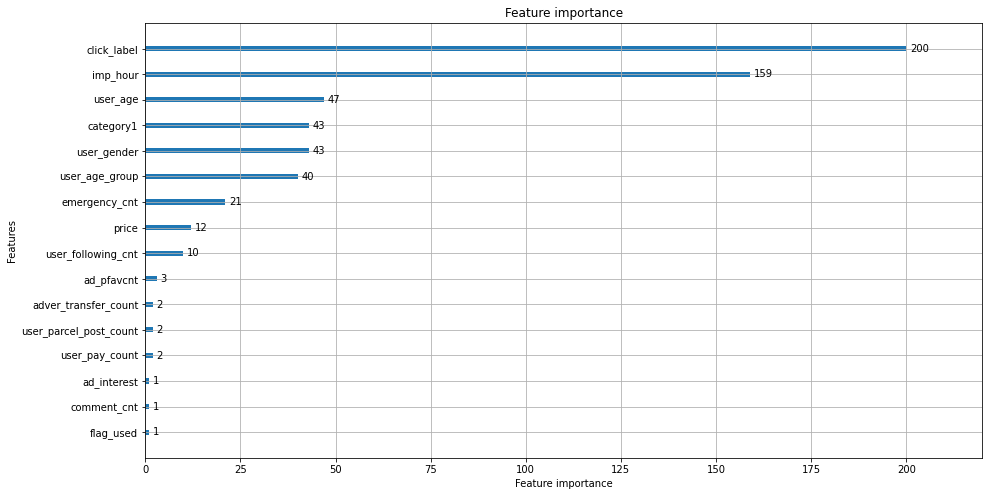

In [70]:
# 특성 중요도를 시각화
fig, ax = plt.subplots(figsize = (15, 8))
plot_importance(lgb_model, ax=ax)
plt.show()

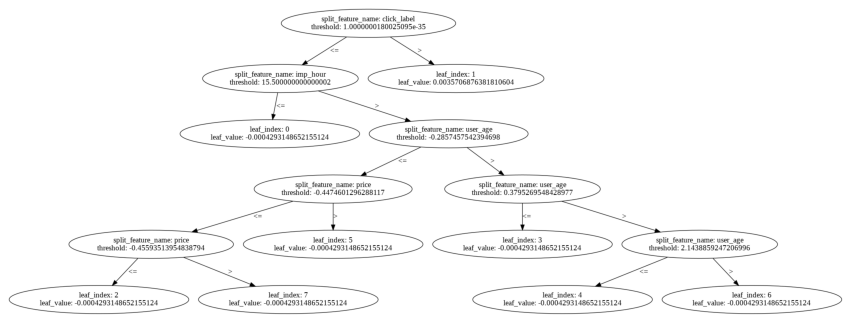

In [71]:
# decision tree를 시각화. 
fig, ax = plt.subplots(figsize = (15, 10))
plot_tree(lgb_model, ax=ax)